# Generative Model Training Tutorial -- RealTabTransformer

This notebook demonstrates how to train generative models for synthetic network trace data generation.

**Example command-line equivalent:**
```bash
python3 driver.py \
    --config_partition small-scale \
    --dataset_name caida \
    --model_name realtabformer-tabular \
    --order_csv_by_timestamp
```


## Step 1: Setup - Import Libraries and Set Parameters

Configure the experiment by setting the model, dataset, and other parameters.


In [2]:
# Import required libraries
import os
import time
import datetime
import pandas as pd
import numpy as np
# ignore all warnings
import warnings
warnings.filterwarnings('ignore')
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("Running on CPU")

# Set experiment parameters (modify these as needed)
config_partition = 'small-scale'  # Options: 'small-scale', 'medium-scale', etc.
dataset_name = 'caida'  # Options: 'caida', 'ugr16', 'cidds', 'ton', 'm57', etc.
model_name = 'tvae'  # Options: 'realtabformer-tabular', 'ctgan', 'tvae', etc.
order_csv_by_timestamp = True  # Whether to sort output by timestamp

# Generate timestamp for this run
now = datetime.datetime.now()
cur_time = now.strftime("%Y%m%d%H%M%S") + str(now.microsecond // 1000).zfill(3)

print(f"Experiment Configuration:")
print(f"  Model: {model_name}")
print(f"  Dataset: {dataset_name}")
print(f"  Config Partition: {config_partition}")
print(f"  Timestamp: {cur_time}")


PyTorch version: 2.1.0+cu121
CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA RTX 4000 Ada Generation
Number of GPUs: 1
Experiment Configuration:
  Model: tvae
  Dataset: caida
  Config Partition: small-scale
  Timestamp: 20251111133908157


## Step 2: Load Configuration and Setup Directories

Load the model and dataset configuration, and create necessary output directories.


In [3]:
# Load configuration based on partition
if config_partition == 'small-scale':
    from config_small_scale import configs, NETGPT_BASE_FOLDER
elif config_partition == 'medium-scale':
    from config_medium_scale import configs, NETGPT_BASE_FOLDER
else:
    raise ValueError(f"Unknown config partition: {config_partition}")

# Setup result directories
RESULT_PATH_BASE = os.path.join(NETGPT_BASE_FOLDER, "results", config_partition)
RESULT_PATH = {
    'runs': os.path.join(RESULT_PATH_BASE, "runs"),
    'csv': os.path.join(RESULT_PATH_BASE, 'csv'),
    'txt': os.path.join(RESULT_PATH_BASE, 'txt'),
    'npz': os.path.join(RESULT_PATH_BASE, 'npz'),
    'time': os.path.join(RESULT_PATH_BASE, 'time'),
}

# Create directories if they don't exist
for path in RESULT_PATH.values():
    os.makedirs(path, exist_ok=True)

# Create work folder for this specific run
work_folder = os.path.join(RESULT_PATH['runs'], f'{model_name}_{dataset_name}_{cur_time}')
os.makedirs(work_folder, exist_ok=True)

# Get configuration for this specific model and dataset
from config_io import Config
current_config = Config(configs[model_name][dataset_name])

print(f"Work folder: {work_folder}")
print(f"\nConfiguration loaded for {model_name} on {dataset_name}")


NETGPT_BASE_FOLDER: /home/lesley/generative-trace-tutorials
Work folder: /home/lesley/generative-trace-tutorials/results/small-scale/runs/tvae_caida_20251111133908157

Configuration loaded for tvae on caida


## Step 3: Load and Inspect the Dataset

Read the raw CSV data and perform initial preprocessing (e.g., drop unnecessary columns).


In [4]:
# Determine dataset type (pcap or netflow)
if dataset_name in ['ugr16', 'cidds', 'ton']:
    dataset_type = 'netflow'
elif dataset_name in ['caida', 'dc', 'ca', 'm57']:
    dataset_type = 'pcap'
else:
    raise ValueError(f"Unknown dataset name: {dataset_name}")

# Load the raw CSV file
df = pd.read_csv(current_config.raw_csv_file)

# For PCAP datasets, drop unnecessary columns (version, ihl, chksum)
if dataset_type == "pcap":
    dropped_columns = []
    for col in ['version', 'ihl', 'chksum']:
        if col in df.columns:
            dropped_columns.append(col)
    if dropped_columns:
        df.drop(columns=dropped_columns, inplace=True)
        print(f"Dropped columns: {dropped_columns}")

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dropped columns: ['version', 'ihl', 'chksum']

Dataset shape: (100000, 104)
Columns: ['srcip_31', 'srcip_30', 'srcip_29', 'srcip_28', 'srcip_27', 'srcip_26', 'srcip_25', 'srcip_24', 'srcip_23', 'srcip_22', 'srcip_21', 'srcip_20', 'srcip_19', 'srcip_18', 'srcip_17', 'srcip_16', 'srcip_15', 'srcip_14', 'srcip_13', 'srcip_12', 'srcip_11', 'srcip_10', 'srcip_9', 'srcip_8', 'srcip_7', 'srcip_6', 'srcip_5', 'srcip_4', 'srcip_3', 'srcip_2', 'srcip_1', 'srcip_0', 'dstip_31', 'dstip_30', 'dstip_29', 'dstip_28', 'dstip_27', 'dstip_26', 'dstip_25', 'dstip_24', 'dstip_23', 'dstip_22', 'dstip_21', 'dstip_20', 'dstip_19', 'dstip_18', 'dstip_17', 'dstip_16', 'dstip_15', 'dstip_14', 'dstip_13', 'dstip_12', 'dstip_11', 'dstip_10', 'dstip_9', 'dstip_8', 'dstip_7', 'dstip_6', 'dstip_5', 'dstip_4', 'dstip_3', 'dstip_2', 'dstip_1', 'dstip_0', 'srcport_15', 'srcport_14', 'srcport_13', 'srcport_12', 'srcport_11', 'srcport_10', 'srcport_9', 'srcport_8', 'srcport_7', 'srcport_6', 'srcport_5', 'srcport_4', 'src

,srcip_31,srcip_30,srcip_29,srcip_28,srcip_27,srcip_26,srcip_25,srcip_24,srcip_23,srcip_22,...,dstport_1,dstport_0,proto,time,pkt_len,tos,id,flag,off,ttl
0,1,0,0,1,0,0,1,1,1,1,...,1,0,TCP,1521118773289502,40,40,0,2,0,52
1,1,0,0,0,1,1,0,0,1,1,...,1,1,TCP,1521118773289519,1500,0,15922,2,0,60
2,1,1,0,1,1,0,0,1,1,1,...,0,1,TCP,1521118773289529,1400,24,3559,2,0,55
3,1,1,0,0,0,1,0,1,0,0,...,0,0,TCP,1521118773289530,52,0,47404,2,0,59
4,1,0,0,0,1,1,0,0,1,1,...,1,1,TCP,1521118773289535,1500,0,15923,2,0,60


## Step 4: Initialize the Model

Create and configure the generative model based on the selected model type.


In [5]:
# Record start time
start_time = time.time()

# Initialize model based on model_name
if model_name == "realtabformer-tabular":
    from realtabformer import REaLTabFormer
    from transformers.models.gpt2 import GPT2Config
    
    # Configure the model architecture
    rtf_model = REaLTabFormer(
        model_type="tabular",
        tabular_config=GPT2Config(
            n_layer=getattr(current_config, 'n_layer', 12),
            n_head=getattr(current_config, 'n_head', 12),
            n_embd=getattr(current_config, 'n_embd', 768)
        ),
        checkpoints_dir=os.path.join(work_folder, "rtf_checkpoints"),
        samples_save_dir=os.path.join(work_folder, "rtf_samples"),
        gradient_accumulation_steps=4,
        epochs=current_config.epochs,
        batch_size=16,
        logging_steps=current_config.logging_steps,
        save_steps=current_config.save_steps,
        save_total_limit=current_config.save_total_limit,
        eval_steps=current_config.eval_steps
    )
    print("REaLTabFormer model initialized")

elif model_name == "ctgan":
    from ctgan import CTGAN
    
    discrete_columns = current_config['discrete_columns']
    ctgan = CTGAN(epochs=100, verbose=True)
    print(f"CTGAN model initialized with discrete columns: {discrete_columns}")

elif model_name == "tvae":
    from ctgan import TVAE
    
    discrete_columns = current_config['discrete_columns']
    tvae = TVAE(epochs=100)
    print(f"TVAE model initialized with discrete columns: {discrete_columns}")

else:
    raise ValueError(f"Model {model_name} not implemented in this tutorial")

print(f"Model configuration complete!")


TVAE model initialized with discrete columns: ['srcip_31', 'srcip_30', 'srcip_29', 'srcip_28', 'srcip_27', 'srcip_26', 'srcip_25', 'srcip_24', 'srcip_23', 'srcip_22', 'srcip_21', 'srcip_20', 'srcip_19', 'srcip_18', 'srcip_17', 'srcip_16', 'srcip_15', 'srcip_14', 'srcip_13', 'srcip_12', 'srcip_11', 'srcip_10', 'srcip_9', 'srcip_8', 'srcip_7', 'srcip_6', 'srcip_5', 'srcip_4', 'srcip_3', 'srcip_2', 'srcip_1', 'srcip_0', 'dstip_31', 'dstip_30', 'dstip_29', 'dstip_28', 'dstip_27', 'dstip_26', 'dstip_25', 'dstip_24', 'dstip_23', 'dstip_22', 'dstip_21', 'dstip_20', 'dstip_19', 'dstip_18', 'dstip_17', 'dstip_16', 'dstip_15', 'dstip_14', 'dstip_13', 'dstip_12', 'dstip_11', 'dstip_10', 'dstip_9', 'dstip_8', 'dstip_7', 'dstip_6', 'dstip_5', 'dstip_4', 'dstip_3', 'dstip_2', 'dstip_1', 'dstip_0', 'srcport_15', 'srcport_14', 'srcport_13', 'srcport_12', 'srcport_11', 'srcport_10', 'srcport_9', 'srcport_8', 'srcport_7', 'srcport_6', 'srcport_5', 'srcport_4', 'srcport_3', 'srcport_2', 'srcport_1', 'src

## Step 5: Train the Model and Generate Synthetic Data

Train the model on the dataset and generate synthetic samples.


In [6]:
# Train the model and generate synthetic data
if model_name == "realtabformer-tabular":
    print("Training REaLTabFormer model...")
    rtf_model.fit(df, num_bootstrap=current_config.num_bootstrap)
    
    # Record training completion time
    end_time_train = time.time()
    training_time_elapsed = end_time_train - start_time
    print(f"Training completed in {training_time_elapsed:.2f} seconds ({training_time_elapsed/3600:.2f} hours)")
    
    # Save the trained model
    rtf_model.save(os.path.join(work_folder, "rtf_model"))
    print("Model saved!")
    
    # Generate synthetic samples
    print(f"\nGenerating {len(df)} synthetic samples...")
    syn_df = rtf_model.sample(n_samples=len(df), gen_batch=1024)

elif model_name == "ctgan":
    print("Training CTGAN model...")
    ctgan.fit(df, discrete_columns)
    
    # Record training completion time
    end_time_train = time.time()
    training_time_elapsed = end_time_train - start_time
    print(f"Training completed in {training_time_elapsed:.2f} seconds ({training_time_elapsed/3600:.2f} hours)")
    
    # Save the trained model
    ctgan.save(os.path.join(work_folder, "model.pt"))
    print("Model saved!")
    
    # Generate synthetic samples
    print(f"\nGenerating {len(df)} synthetic samples...")
    syn_df = ctgan.sample(len(df))

elif model_name == "tvae":
    print("Training TVAE model...")
    tvae.fit(df, discrete_columns)
    
    # Record training completion time
    end_time_train = time.time()
    training_time_elapsed = end_time_train - start_time
    print(f"Training completed in {training_time_elapsed:.2f} seconds ({training_time_elapsed/3600:.2f} hours)")
    
    # Save the trained model
    tvae.save(os.path.join(work_folder, "model.pt"))
    print("Model saved!")
    
    # Generate synthetic samples
    print(f"\nGenerating {len(df)} synthetic samples...")
    syn_df = tvae.sample(len(df))

print(f"\nSynthetic data generation complete!")
print(f"Synthetic data shape: {syn_df.shape}")
print(f"\nFirst few rows of synthetic data:")
syn_df.head()


Training TVAE model...
Start data transformation...
Data transformation finished!
Data dimension:  246
Training completed in 159.02 seconds (0.04 hours)
Model saved!

Generating 100000 synthetic samples...

Synthetic data generation complete!
Synthetic data shape: (100000, 104)

First few rows of synthetic data:


,srcip_31,srcip_30,srcip_29,srcip_28,srcip_27,srcip_26,srcip_25,srcip_24,srcip_23,srcip_22,...,dstport_1,dstport_0,proto,time,pkt_len,tos,id,flag,off,ttl
0,0,0,0,0,0,0,0,0,0,0,...,1,0,TCP,1521118773500643,1502,0,64969,2,0,59
1,0,0,0,1,1,0,1,0,1,1,...,1,1,TCP,1521118773436139,1504,0,63046,2,0,59
2,0,1,0,1,0,1,0,1,0,1,...,0,0,TCP,1521118773484115,62,0,-177,2,0,242
3,1,1,0,1,1,1,1,0,1,1,...,1,1,TCP,1521118773484018,1504,0,34093,2,0,60
4,1,1,0,1,1,0,1,0,1,1,...,1,1,TCP,1521118773465639,1495,0,63397,2,0,58


## Step 6: Post-process and Save Results

Apply any necessary post-processing and save the synthetic data to a CSV file.


In [7]:
# Function to convert bit columns to decimal (for CTGAN/TVAE models)
def csv_bit2decimal(input_df):
    """Convert bit-encoded IP addresses and ports to decimal format"""
    df = input_df.copy(deep=True)
    
    # Convert srcip from bits to decimal
    srcip_cols = df.loc[:, [f"srcip_{31-i}" for i in range(32)]]
    srcip_decimal = srcip_cols.apply(lambda x: int(''.join(x.astype(str)), 2), axis=1)
    df["srcip"] = srcip_decimal

    # Convert dstip from bits to decimal
    dstip_cols = df.loc[:, [f"dstip_{31-i}" for i in range(32)]]
    dstip_decimal = dstip_cols.apply(lambda x: int(''.join(x.astype(str)), 2), axis=1)
    df["dstip"] = dstip_decimal

    # Convert srcport from bits to decimal
    srcport_cols = df.loc[:, [f"srcport_{15-i}" for i in range(16)]]
    srcport_decimal = srcport_cols.apply(lambda x: int(''.join(x.astype(str)), 2), axis=1)
    df["srcport"] = srcport_decimal

    # Convert dstport from bits to decimal
    dstport_cols = df.loc[:, [f"dstport_{15-i}" for i in range(16)]]
    dstport_decimal = dstport_cols.apply(lambda x: int(''.join(x.astype(str)), 2), axis=1)
    df["dstport"] = dstport_decimal

    # Drop the bit columns
    df = df.drop(columns=([f"srcip_{31-i}" for i in range(32)] +
                          [f"dstip_{31-i}" for i in range(32)] +
                          [f"srcport_{15-i}" for i in range(16)] +
                          [f"dstport_{15-i}" for i in range(16)]))

    return df

# Convert bit columns to decimal if needed (for CTGAN/TVAE)
if model_name in ['ctgan', 'tvae']:
    print("Converting bit columns to decimal format...")
    syn_df = csv_bit2decimal(syn_df)
    print(f"Converted data shape: {syn_df.shape}")

# Function to validate and fix synthetic dataframe
def check_and_fix_syndf(syn_df, dataset_type, order_by_timestamp=False):
    """Validate data types and reorder columns"""
    # Ensure correct data types
    if syn_df['srcip'].dtype != int or syn_df['dstip'].dtype != int:
        raise ValueError("srcip and dstip should be int")
    
    if dataset_type == 'pcap':
        # Add constant columns for PCAP
        syn_df['version'] = 4
        syn_df['ihl'] = 5
        
        # Ensure integer types for specific columns
        for col in ['time', 'pkt_len', 'tos', 'id', 'flag', 'off', 'ttl']:
            syn_df[col] = syn_df[col].astype(int)
        
        # Reorder columns (important for downstream processing)
        syn_df = syn_df[['srcip', 'dstip', 'srcport', 'dstport', 'proto', 
                         'time', 'pkt_len', 'version', 'ihl', 'tos', 'id', 'flag', 'off', 'ttl']]
        time_col = 'time'
    
    elif dataset_type == 'netflow':
        # Ensure integer types for specific columns
        for col in ['ts', 'pkt', 'byt']:
            syn_df[col] = syn_df[col].astype(int)
        
        # Reorder columns based on what's available
        if 'label' in syn_df.columns and 'type' in syn_df.columns:
            syn_df = syn_df[['srcip', 'dstip', 'srcport', 'dstport', 'proto', 
                             'ts', 'td', 'pkt', 'byt', 'label', 'type']]
        elif 'type' in syn_df.columns:
            syn_df = syn_df[['srcip', 'dstip', 'srcport', 'dstport', 'proto', 
                             'ts', 'td', 'pkt', 'byt', 'type']]
        time_col = 'ts'
    
    # Sort by timestamp if requested
    if order_by_timestamp:
        syn_df = syn_df.sort_values(by=[time_col])
    
    return syn_df

# Post-process the synthetic data
syn_df = check_and_fix_syndf(syn_df, dataset_type, order_csv_by_timestamp)

# Save synthetic data to CSV
output_csv_path = os.path.join(RESULT_PATH['csv'], f'{model_name}_{dataset_name}_{cur_time}.csv')
syn_df.to_csv(output_csv_path, index=False)
print(f"Synthetic data saved to: {output_csv_path}")

# Calculate and save execution time
end_time = time.time()
time_elapsed = end_time - start_time
generation_time = time_elapsed - training_time_elapsed

time_file_path = os.path.join(RESULT_PATH['time'], f'{model_name}_{dataset_name}_{cur_time}.txt')
with open(time_file_path, 'w') as f:
    f.write(f"=== Time Breakdown ===\n")
    f.write(f"Training time: {training_time_elapsed:.2f} seconds ({training_time_elapsed / 3600:.2f} hours)\n")
    f.write(f"Generation time: {generation_time:.2f} seconds ({generation_time / 3600:.2f} hours)\n")
    f.write(f"Total time: {time_elapsed:.2f} seconds ({time_elapsed / 3600:.2f} hours)\n")
    f.write(f"\n=== Timestamps ===\n")
    f.write(f"start_time: {datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"end_time_train: {datetime.datetime.fromtimestamp(end_time_train).strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"end_time: {datetime.datetime.fromtimestamp(end_time).strftime('%Y-%m-%d %H:%M:%S')}\n")

print(f"\nTime Breakdown:")
print(f"  Training:   {training_time_elapsed:.2f} seconds ({training_time_elapsed / 3600:.2f} hours)")
print(f"  Generation: {generation_time:.2f} seconds ({generation_time / 3600:.2f} hours)")
print(f"  Total:      {time_elapsed:.2f} seconds ({time_elapsed / 3600:.2f} hours)")
print(f"\nTime log saved to: {time_file_path}")
print("\n=== Training and Generation Complete! ===")


Converting bit columns to decimal format...
Converted data shape: (100000, 12)
Synthetic data saved to: /home/lesley/generative-trace-tutorials/results/small-scale/csv/tvae_caida_20251111133908157.csv

Time Breakdown:
  Training:   159.02 seconds (0.04 hours)
  Generation: 124.42 seconds (0.03 hours)
  Total:      283.44 seconds (0.08 hours)

Time log saved to: /home/lesley/generative-trace-tutorials/results/small-scale/time/tvae_caida_20251111133908157.txt

=== Training and Generation Complete! ===


## Eval #1: Fidelity Check

Evaluate the quality of the generated synthetic data by comparing it against the real data using various statistical queries.


In [8]:
# Import evaluation metrics
from metric import eval_metrics

# Prepare the real data for evaluation
real_df = df.copy()

# Convert bit columns to decimal for real data (if needed)
if model_name in ['ctgan', 'tvae']:
    print("Converting real data bit columns to decimal format...")
    real_df = csv_bit2decimal(real_df)
    print(f"Real data converted shape: {real_df.shape}")

# Add missing columns for PCAP data (version, ihl) if needed
if dataset_type == 'pcap':
    if 'version' not in real_df.columns:
        real_df['version'] = 4
    if 'ihl' not in real_df.columns:
        real_df['ihl'] = 5

# Load the generated synthetic data
gen_df = pd.read_csv(output_csv_path)

print(f"\nReal data shape: {real_df.shape}")
print(f"Generated data shape: {gen_df.shape}")
print(f"Real data columns: {list(real_df.columns)}")
print(f"Generated data columns: {list(gen_df.columns)}")
print("\nRunning comprehensive fidelity evaluation...")
print("This may take a few minutes depending on data size...\n")

# Run evaluation with multiple metrics
# n=10 means we look at top-10 values for various distributions
# n_threads controls parallel processing (adjust based on your CPU)
rst = eval_metrics(real_df, gen_df, n=10, n_threads=16)


Converting real data bit columns to decimal format...
Real data converted shape: (100000, 12)

Real data shape: (100000, 14)
Generated data shape: (100000, 14)
Real data columns: ['proto', 'time', 'pkt_len', 'tos', 'id', 'flag', 'off', 'ttl', 'srcip', 'dstip', 'srcport', 'dstport', 'version', 'ihl']
Generated data columns: ['srcip', 'dstip', 'srcport', 'dstport', 'proto', 'time', 'pkt_len', 'version', 'ihl', 'tos', 'id', 'flag', 'off', 'ttl']

Running comprehensive fidelity evaluation...
This may take a few minutes depending on data size...



Evaluating Flow Stateful Metrics: 100%|██████████| 42/42 [00:22<00:00,  1.83metric/s]


## Visualize Fidelity Results

Plot the evaluation metrics to visualize the quality of synthetic data across different queries.



Average Scores by Category:
  Packet-Level:            0.4617
  Flow-Level Stateless:    0.6654
  Flow-Level Stateful:     0.5012

Generating visualizations...



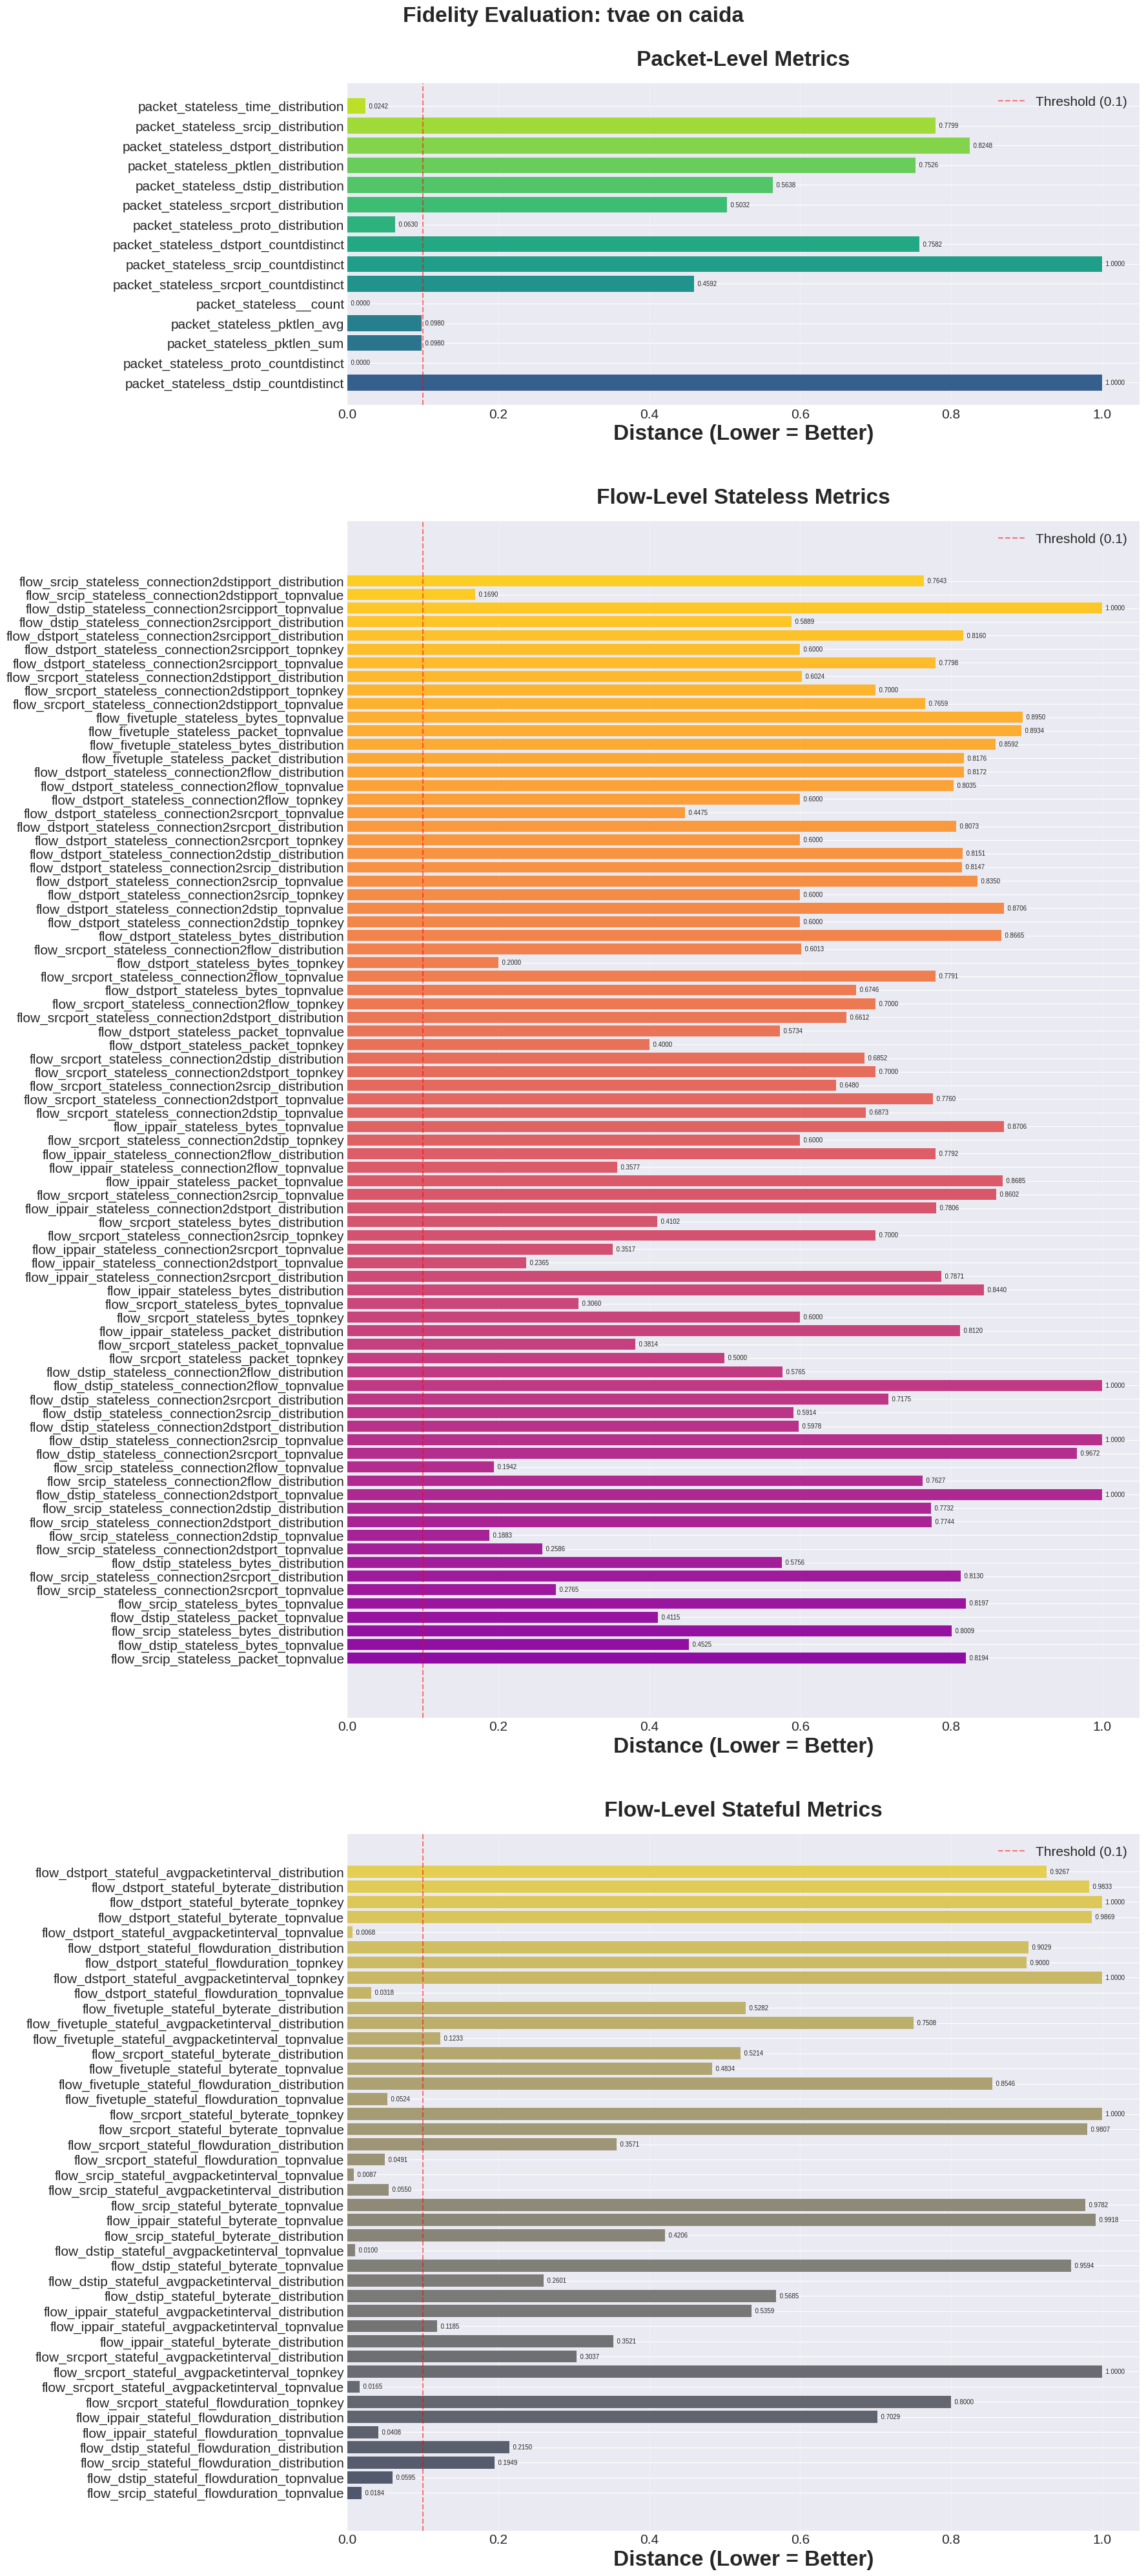


SUMMARY STATISTICS
Total metrics evaluated: 137
Average distance: 0.5927
Median distance: 0.6746
Min distance: 0.0000
Max distance: 1.0000
Metrics below 0.1 threshold: 17/137 (12.4%)


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Display average scores for each category
print("\nAverage Scores by Category:")
print(f"  Packet-Level:            {rst['packet']['avg']:.4f}")
print(f"  Flow-Level Stateless:    {rst['flow_stateless']['avg']:.4f}")
print(f"  Flow-Level Stateful:     {rst['flow_stateful']['avg']:.4f}")
print("\nGenerating visualizations...\n")

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(18, 40))

# ===== Plot 1: Packet-Level Metrics =====
ax1 = plt.subplot2grid((40, 1), (0, 0), rowspan=6, fig=fig)
packet_metrics = rst['packet']['score']  # Extract the 'score' dictionary
metric_names = list(packet_metrics.keys())
metric_values = list(packet_metrics.values())

# Create color map for better visualization
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(metric_names)))

bars1 = ax1.barh(metric_names, metric_values, color=colors[:len(metric_names)])
ax1.set_xlabel('Distance (Lower = Better)', fontsize=24, fontweight='bold')
ax1.set_title('Packet-Level Metrics', fontsize=24, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (name, value) in enumerate(zip(metric_names, metric_values)):
    ax1.text(value, i, f'  {value:.4f}', va='center', fontsize=7)

# Add a reference line at a good threshold (e.g., 0.1)
ax1.axvline(x=0.1, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Threshold (0.1)')
ax1.legend(loc='upper right')

# ===== Plot 2: Flow-Level Stateless Metrics =====
ax2 = plt.subplot2grid((40, 1), (7, 0), rowspan=20, fig=fig)
stateless_metrics = rst['flow_stateless']['score']  # Extract the 'score' dictionary
metric_names_sl = list(stateless_metrics.keys())
metric_values_sl = list(stateless_metrics.values())

colors_sl = plt.cm.plasma(np.linspace(0.3, 0.9, len(metric_names_sl)))
bars2 = ax2.barh(metric_names_sl, metric_values_sl, color=colors_sl)
ax2.set_xlabel('Distance (Lower = Better)', fontsize=24, fontweight='bold')
ax2.set_title('Flow-Level Stateless Metrics', fontsize=24, fontweight='bold', pad=20)
ax2.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (name, value) in enumerate(zip(metric_names_sl, metric_values_sl)):
    ax2.text(value, i, f'  {value:.4f}', va='center', fontsize=7)

# Add reference line
ax2.axvline(x=0.1, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Threshold (0.1)')
ax2.legend(loc='upper right')

# ===== Plot 3: Flow-Level Stateful Metrics =====
ax3 = plt.subplot2grid((40, 1), (28, 0), rowspan=12, fig=fig)
stateful_metrics = rst['flow_stateful']['score']  # Extract the 'score' dictionary
metric_names_sf = list(stateful_metrics.keys())
metric_values_sf = list(stateful_metrics.values())

colors_sf = plt.cm.cividis(np.linspace(0.3, 0.9, len(metric_names_sf)))
bars3 = ax3.barh(metric_names_sf, metric_values_sf, color=colors_sf)
ax3.set_xlabel('Distance (Lower = Better)', fontsize=24, fontweight='bold')
ax3.set_title('Flow-Level Stateful Metrics', fontsize=24, fontweight='bold', pad=20)
ax3.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (name, value) in enumerate(zip(metric_names_sf, metric_values_sf)):
    ax3.text(value, i, f'  {value:.4f}', va='center', fontsize=7)

# Add reference line
ax3.axvline(x=0.1, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Threshold (0.1)')
ax3.legend(loc='upper right')

# Overall title
fig.suptitle(f'Fidelity Evaluation: {model_name} on {dataset_name}', 
             fontsize=24, fontweight='bold', y=0.998)

plt.tight_layout()
plt.show()

# Calculate and display summary statistics
all_values = metric_values + metric_values_sl + metric_values_sf
print(f"\n{'='*60}")
print(f"SUMMARY STATISTICS")
print(f"{'='*60}")
print(f"Total metrics evaluated: {len(all_values)}")
print(f"Average distance: {np.mean(all_values):.4f}")
print(f"Median distance: {np.median(all_values):.4f}")
print(f"Min distance: {np.min(all_values):.4f}")
print(f"Max distance: {np.max(all_values):.4f}")
below_threshold = sum(v < 0.1 for v in all_values)
print(f"Metrics below 0.1 threshold: {below_threshold}/{len(all_values)} ({100*below_threshold/len(all_values):.1f}%)")
print(f"{'='*60}")


## Eval #2: Cost Analysis

Analyze the cost-effectiveness of storing the generative model vs. storing raw data.


In [10]:
import os

# Use training time (tracked in Step 5) - excludes generation time
training_time_seconds = training_time_elapsed
training_time_hours = training_time_seconds / 3600.0

# Also show total time for reference
total_time_seconds = time_elapsed
total_time_hours = total_time_seconds / 3600.0
generation_time_seconds = total_time_seconds - training_time_seconds
generation_time_hours = generation_time_seconds / 3600.0

print("="*60)
print("GENERATIVE AI MODEL COST ANALYSIS")
print("="*60)

# ===== Time Breakdown =====
print(f"\n1️⃣ Time Breakdown:")
print(f"   Training time:    {training_time_seconds:.2f} seconds ({training_time_hours:.4f} hours)")
print(f"   Generation time:  {generation_time_seconds:.2f} seconds ({generation_time_hours:.4f} hours)")
print(f"   Total time:       {total_time_seconds:.2f} seconds ({total_time_hours:.4f} hours)")

# ===== Model Size =====
def get_directory_size(path):
    """Calculate total size of directory in bytes"""
    total_size = 0
    if os.path.isfile(path):
        return os.path.getsize(path)
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            if os.path.exists(filepath):
                total_size += os.path.getsize(filepath)
    return total_size

# Get model directory based on model type
if model_name == "realtabformer-tabular":
    model_path = os.path.join(work_folder, "rtf_model")
elif model_name in ["ctgan", "tvae"]:
    model_path = os.path.join(work_folder, "model.pt")
else:
    model_path = work_folder

model_size_bytes = get_directory_size(model_path)
model_size_mb = model_size_bytes / (1024**2)
model_size_gb = model_size_bytes / (1024**3)

print(f"\n2️⃣ Model Storage:")
print(f"   Size: {model_size_bytes:,} bytes ({model_size_mb:.2f} MB / {model_size_gb:.4f} GB)")
print(f"   Path: {model_path}")

# ===== Cost Parameters =====
# Adjust these parameters based on your cloud provider
gpu_rate_per_hour = 0.20  # $ per hour (typical cloud GPU cost, e.g., AWS p3.2xlarge ~$3/hr, GCP T4 ~$0.35/hr)
storage_rate_gb_year = 0.024  # $ per GB per year (AWS S3 standard ~$0.023/GB/month = $0.276/GB/year)

print(f"\n3️⃣ Cost Parameters:")
print(f"   GPU rate:     ${gpu_rate_per_hour:.2f} per hour")
print(f"   Storage rate: ${storage_rate_gb_year:.4f} per GB per year")

# ===== Calculate Costs =====
training_cost = training_time_hours * gpu_rate_per_hour
model_storage_cost_per_year = model_size_gb * storage_rate_gb_year
total_cost_year1 = training_cost + model_storage_cost_per_year

print(f"\n{'='*60}")
print("COST BREAKDOWN")
print(f"{'='*60}")
print(f"\n💰 Training Cost (one-time):")
print(f"   {training_time_hours:.4f} hours × ${gpu_rate_per_hour:.2f}/hour = ${training_cost:.2f}")

print(f"\n💾 Storage Cost (annual):")
print(f"   {model_size_gb:.4f} GB × ${storage_rate_gb_year:.4f}/GB/year = ${model_storage_cost_per_year:.4f}/year")

print(f"\n📊 Total Cost:")
print(f"   Year 1: ${total_cost_year1:.2f} (training + 1 year storage)")
print(f"   Year 2+: ${model_storage_cost_per_year:.4f} per year (storage only)")

# ===== Multi-Year Projection =====
print(f"\n{'='*60}")
print("MULTI-YEAR COST PROJECTION")
print(f"{'='*60}")
print(f"\n{'Year':<8} {'Storage Cost':<20} {'Cumulative Cost':<20}")
print("-" * 48)

for year in [1, 2, 3, 5, 10]:
    yearly_storage = model_storage_cost_per_year
    cumulative_cost = training_cost + (year * model_storage_cost_per_year)
    print(f"{year:<8} ${yearly_storage:<19.4f} ${cumulative_cost:<19.2f}")

print(f"\n{'='*60}")
print("✓ Generative AI Model Cost Analysis Complete!")
print(f"{'='*60}")

print(f"\n📌 Summary:")
print(f"   • One-time training cost: ${training_cost:.2f}")
print(f"   • Annual storage cost: ${model_storage_cost_per_year:.4f}")
print(f"   • Total first-year cost: ${total_cost_year1:.2f}")
print(f"   • Model size: {model_size_mb:.2f} MB ({model_size_gb:.4f} GB)")


GENERATIVE AI MODEL COST ANALYSIS

1️⃣ Time Breakdown:
   Training time:    159.02 seconds (0.0442 hours)
   Generation time:  124.42 seconds (0.0346 hours)
   Total time:       283.44 seconds (0.0787 hours)

2️⃣ Model Storage:
   Size: 1,900,291 bytes (1.81 MB / 0.0018 GB)
   Path: /home/lesley/generative-trace-tutorials/results/small-scale/runs/tvae_caida_20251111133908157/model.pt

3️⃣ Cost Parameters:
   GPU rate:     $0.20 per hour
   Storage rate: $0.0240 per GB per year

COST BREAKDOWN

💰 Training Cost (one-time):
   0.0442 hours × $0.20/hour = $0.01

💾 Storage Cost (annual):
   0.0018 GB × $0.0240/GB/year = $0.0000/year

📊 Total Cost:
   Year 1: $0.01 (training + 1 year storage)
   Year 2+: $0.0000 per year (storage only)

MULTI-YEAR COST PROJECTION

Year     Storage Cost         Cumulative Cost     
------------------------------------------------
1        $0.0000              $0.01               
2        $0.0000              $0.01               
3        $0.0000             